In [7]:
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

# 加载数据

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

data_dir='../../data/2_class'
data_root=pathlib.Path(data_dir)

In [9]:
for item in data_root.iterdir():
    print(item)

..\..\data\2_class\airplane
..\..\data\2_class\lake


In [10]:
#所有数据地址
all_image_path=list(data_root.glob('*/*'))
len(all_image_path)

1400

In [11]:
all_image_path[:3],all_image_path[-3:]

([WindowsPath('../../data/2_class/airplane/airplane_001.jpg'),
  WindowsPath('../../data/2_class/airplane/airplane_002.jpg'),
  WindowsPath('../../data/2_class/airplane/airplane_003.jpg')],
 [WindowsPath('../../data/2_class/lake/lake_698.jpg'),
  WindowsPath('../../data/2_class/lake/lake_699.jpg'),
  WindowsPath('../../data/2_class/lake/lake_700.jpg')])

**图片地址**

In [12]:
all_image_path=[str(path)for path in all_image_path]
all_image_path[0:2]

['..\\..\\data\\2_class\\airplane\\airplane_001.jpg',
 '..\\..\\data\\2_class\\airplane\\airplane_002.jpg']

In [13]:
import random

In [16]:
random.shuffle(all_image_path)#乱序
all_image_path[0:2]

['..\\..\\data\\2_class\\lake\\lake_642.jpg',
 '..\\..\\data\\2_class\\airplane\\airplane_254.jpg']

In [15]:
image_count=len(all_image_path)
image_count

1400

**通过sorted排列列表**

In [20]:
#将label返回成列表
labels_names=sorted(item.name for item in data_root.glob('*/'))
labels_names

['airplane', 'lake']

**enumerate方法将可迭代对象转化为元组列表**

In [10]:
#编码
label_to_index=dict((name,index) for index,name in enumerate(labels_names))#enumerate将一个列表转化为索引列表，丛零开始
label_to_index

{'airplane': 0, 'lake': 1}

**通过索引对label进行0/1编码**

In [11]:
#通过字典，将lake，airplane编码成0和1
all_image_label=[label_to_index[pathlib.Path(p).parent.name] for p in all_image_path]
all_image_label[:5],all_image_path[:5]

([1, 0, 1, 0, 1],
 ['..\\data\\2_class\\lake\\lake_432.jpg',
  '..\\data\\2_class\\airplane\\airplane_414.jpg',
  '..\\data\\2_class\\lake\\lake_635.jpg',
  '..\\data\\2_class\\airplane\\airplane_607.jpg',
  '..\\data\\2_class\\lake\\lake_419.jpg'])

**显示图片**

In [12]:
import IPython.display as display

In [13]:
index_to_label = dict((v,k) for k,v,in label_to_index.items())
index_to_label

{0: 'airplane', 1: 'lake'}

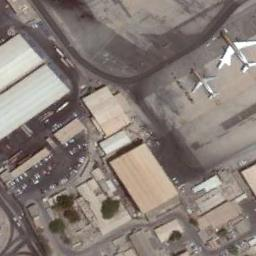

airplane


In [14]:
#查看图像内容
for n in range(1):
    image_index = random.choice(range(len(all_image_path)))
    display.display(display.Image(all_image_path[image_index]))
    print(index_to_label[all_image_label[image_index]])
    print()

# 单张图片的处理过程

In [16]:
img_path=all_image_path[0]
img_path

'..\\data\\2_class\\lake\\lake_432.jpg'

In [17]:
img_raw=tf.io.read_file(img_path)#读取图片
img_tensor=tf.image.decode_image(img_raw)#图片解码

In [19]:
img_tensor=tf.cast(img_tensor,tf.float32)#转换数据类型
img_tensor=img_tensor/255#图片归一化
print(img_tensor.shape)

(256, 256, 3)


In [21]:
def load_preprocess_image(path):
    img_raw=tf.io.read_file(path)#读取图片
    img_tensor=tf.image.decode_jpeg(img_raw,channels=3)#图片解码
    img_tensor=tf.image.resize(img_tensor,[256,256])
    img_tensor=tf.cast(img_tensor,tf.float32)#转换数据类型
    img=img_tensor/255#图片归一化
    return img

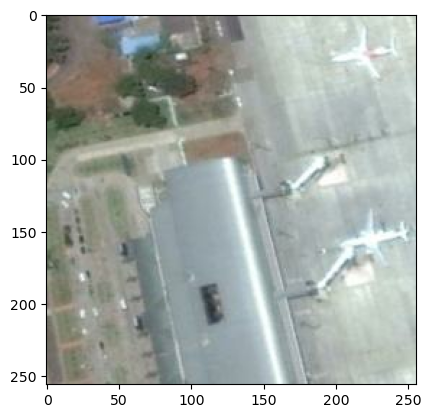

In [22]:
#显示图片
image_path=all_image_path[20]
plt.imshow(load_preprocess_image(image_path))

# 构造tf.data

In [21]:
path_ds=tf.data.Dataset.from_tensor_slices(all_image_path)#从目录加载数据
AUTOTUNE=tf.data.experimental.AUTOTUNE
image_dateset=path_ds.map(load_preprocess_image,num_parallel_calls=AUTOTUNE)
label_dataset=tf.data.Dataset.from_tensor_slices(tf.cast(all_image_label,tf.int64))#这里加载时，通过cast方法将数据转化为64格式

In [22]:
image_dateset,label_dataset

(<_ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>,
 <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>)

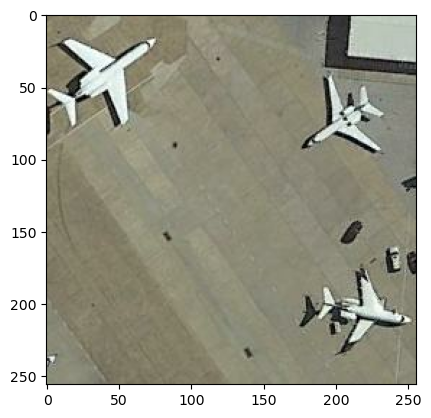

In [23]:
for img in image_dateset.take(1):
    plt.imshow(img)

tf.data.Dataset.zip() 方法可以用於合併兩個數據集，以便可以一起處理它們。
例如，如果 dataset1 包含圖像數據，dataset2 包含標籤數據，那麼 tf.data.Dataset.zip(dataset1, dataset2) 會創建一個數據集，
其中包含圖像和標籤的元組。然後，這個數據集可以一起用於訓練一個圖像分類器。

In [24]:
dataset=tf.data.Dataset.zip((image_dateset,label_dataset))

In [25]:
dataset

<_ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [26]:
test_count=int(image_count*0.2)
train_count=image_count-test_count

In [27]:
test_count,train_count

(280, 1120)

In [28]:
#创建训练数据以及测试数据
train_data = dataset.skip(test_count)
test_data=dataset.take(test_count)

In [29]:
BATCH_SIZE=32

**tf.data.experimental.shuffle_and_repeat() 方法是一種用於將數據集打亂並重複**
apply方法作用是对数据进行处理，将数据转化为另一个数据

tf.data.Dataset.prefetch() 方法會在數據集上預取 buffer_size 個數據。
這意味著當您從數據集中請求數據時，數據集將已經預取了 buffer_size 個數據。這可以提高數據集的性能，因為它可以減少數據集從磁碟或網絡流中讀取數據的次數。

In [30]:
# train_data=train_dataset.repeat().shuffle(buffer_size=train_count).batch(BATCH_SIZE)
train_data = train_data.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_count))
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)#预加载数据

test_data=test_data.batch(BATCH_SIZE)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [31]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# 构建模型

In [32]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'))
# model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())#默认2x2
# model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
# model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())#默认2x2
# model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu'))
# model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())#默认2x2
# model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())#默认2x2
# model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())#默认2x2
# model.add(tf.keras.layers.Conv2D(1024,(3,3),activation='relu'))
# model.add(tf.keras.layers.GlobalAveragePooling2D())#全局平均池化
# model.add(tf.keras.layers.Dense(1024,activation='relu'))
# model.add(tf.keras.layers.Dense(256,activation='relu'))
# # model.add(tf.keras.layers.Dense(2,activation='sigmoid'))
# model.add(tf.keras.layers.Dense(1,activation='sigmoid'))


## 增加BN层

In [33]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3)))#卷积层
model.add(tf.keras.layers.BatchNormalization())#批标准化层
model.add(tf.keras.layers.Activation('relu'))#激活层

model.add(tf.keras.layers.Conv2D(64,(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())#连接层
model.add(tf.keras.layers.Conv2D(128,(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(128,(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())#连接层
model.add(tf.keras.layers.Conv2D(256,(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(256,(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512,(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(512,(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024,(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 254, 254, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 252, 252, 64)      256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 252, 252, 64)      0

In [35]:
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['acc']
# )

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)

In [37]:
steps_per_epoch=train_count//BATCH_SIZE
validation_steps=test_count//BATCH_SIZE

In [38]:
import os,datetime
log_dir = os.path.join(
    'logs', datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

In [39]:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_data,
                    validation_steps=validation_steps,
                    callbacks=[tensorboard_callback])

Epoch 1/5
 4/35 [==>...........................] - ETA: 10:32 - loss: 0.6081 - acc: 0.7344

KeyboardInterrupt: 

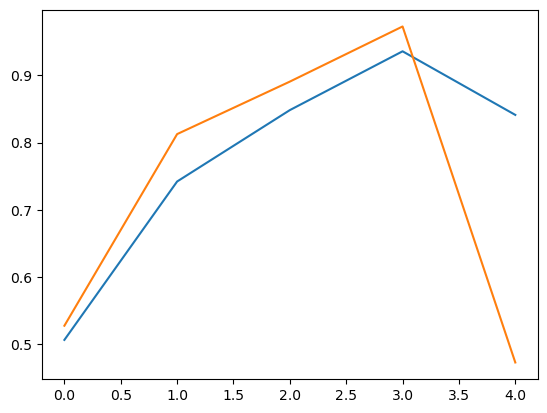

In [44]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')